In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler, DataLoader
from tqdm import tqdm
from PIL import Image

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [4]:
random_seed= 42

In [5]:
#Creating custom dataset
data_path_train = "C:/Users/M/Desktop/Python/Amber/Data/Train3"
data_path_test = "C:/Users/M/Desktop/Python/Amber/Data/Test3"
IMG_SIZE = 224

transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5)),
        ]
    )

class CustomDataSet():
       
    def __init__(self,data_path,transform=None):
        
        self.transform = transform
        
        self.data_path = data_path
        self.data = dset.ImageFolder(self.data_path)
        self.nrofclass = len(self.data.classes)
                
        self.custom_data = []
        
        for i in tqdm(range(len(self.data))):
            ImgPath = self.data.samples[i][0]
            img = cv2.imread(ImgPath)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # gray scale for shape ?
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            Category = self.data.samples[i][1]
            y_label = torch.tensor(np.eye(self.nrofclass)[Category])  # one hot encoding
            #y_label = torch.tensor(Category)
            self.custom_data.append([img, y_label])
           # img.close()
          
    def __len__(self):
        return len(self.custom_data)
    
    def __getitem__(self, idx):
        img, class_id = self.custom_data[idx]
        if self.transform is not None:
            img = self.transform(img)
        return (img, class_id)

DataSetTrain = CustomDataSet(data_path_train,transform=transform)
DataSetTest = CustomDataSet(data_path_test,transform=transform)
DataSetValid = CustomDataSet(data_path_valid,transform=transform)

100%|████████████████████████████████████████████████████████████████████████████| 1102/1102 [00:00<00:00, 2371.30it/s]


In [60]:
valid_size = int(0.2 * len(DataSetTest))
test_size = len(DataSetTest) - valid_size
valid_dataset, test_dataset = torch.utils.data.random_split(DataSetTest, [valid_size, test_size])

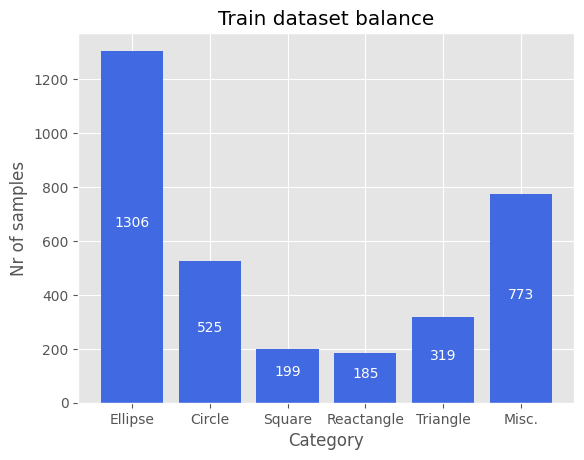

In [61]:
# Checking for class balance
DataSummary = []
for i in range(len(DataSetTrain.data.classes)):
    count = DataSetTrain.data.targets.count(i)
    DataSummary.append(count)

Classes = ('Ellipse', 'Circle', 'Square', 'Reactangle', 'Triangle','Misc.')
DataBalance = dict(zip(Classes,DataSummary))

Categories = list(DataBalance.keys())
Samples = list(DataBalance.values())

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center', color = 'white')

plt.style.use('ggplot')
plt.title('Train dataset balance')
plt.xlabel('Category')
plt.ylabel('Nr of samples')
plt.bar(Categories,Samples, color = 'royalblue')
addlabels(Categories,Samples)
plt.show()

In [62]:
# Initialise class weights

class_weights = []
for i in range(len(DataSetTrain.data.classes)):
    count = DataSetTrain.data.targets.count(i)
    class_weights.append(1/(count))

sample_weights = [0] * len(DataSetTrain)

for idx, (data, label) in enumerate(DataSetTrain.data):
        class_weight = class_weights[label]
        sample_weights[idx] = class_weight

sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

In [63]:
#Data loaders
BATCH_SIZE = 50
train_data_loader = DataLoader(DataSetTrain, 
                               batch_size=BATCH_SIZE,  
                               #shuffle=True
                               sampler=sampler
                               )

test_data_loader = DataLoader(test_dataset, 
                              batch_size=20,  
                             # num_workers=0,
                              shuffle=False
                              )

valid_data_loader = DataLoader(valid_dataset, 
                              batch_size=20,  
                             # num_workers=0,
                              shuffle=False
                              )


In [ ]:
len(DataSetTest)

In [10]:
from torch import Tensor
from typing import Callable, Any, List, Optional

def channel_shuffle(x: Tensor, groups: int) -> Tensor:
    batchsize, num_channels, height, width = x.size()
    channels_per_group = num_channels // groups

    # reshape
    x = x.view(batchsize, groups, channels_per_group, height, width)

    x = torch.transpose(x, 1, 2).contiguous()

    # flatten
    x = x.view(batchsize, -1, height, width)

    return x

class InvertedResidual(nn.Module):
    def __init__(self, inp: int, oup: int, stride: int) -> None:
        super().__init__()

        if not (1 <= stride <= 3):
            raise ValueError("illegal stride value")
        self.stride = stride

        branch_features = oup // 2
        if (self.stride == 1) and (inp != branch_features << 1):
            raise ValueError(
                f"Invalid combination of stride {stride}, inp {inp} and oup {oup} values. If stride == 1 then inp should be equal to oup // 2 << 1."
            )

        if self.stride > 1:
            self.branch1 = nn.Sequential(
                self.depthwise_conv(inp, inp, kernel_size=3, stride=self.stride, padding=1),
                nn.BatchNorm2d(inp),
                nn.Conv2d(inp, branch_features, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(branch_features),
                nn.ReLU(inplace=True),
            )
        else:
            self.branch1 = nn.Sequential()

        self.branch2 = nn.Sequential(
            nn.Conv2d(
                inp if (self.stride > 1) else branch_features,
                branch_features,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.BatchNorm2d(branch_features),
            nn.ReLU(inplace=True),
            self.depthwise_conv(branch_features, branch_features, kernel_size=3, stride=self.stride, padding=1),
            nn.BatchNorm2d(branch_features),
            nn.Conv2d(branch_features, branch_features, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(branch_features),
            nn.ReLU(inplace=True),
        )

    @staticmethod
    def depthwise_conv(
        i: int, o: int, kernel_size: int, stride: int = 1, padding: int = 0, bias: bool = False
    ) -> nn.Conv2d:
        return nn.Conv2d(i, o, kernel_size, stride, padding, bias=bias, groups=i)

    def forward(self, x: Tensor) -> Tensor:
        if self.stride == 1:
            x1, x2 = x.chunk(2, dim=1)
            out = torch.cat((x1, self.branch2(x2)), dim=1)
        else:
            out = torch.cat((self.branch1(x), self.branch2(x)), dim=1)

        out = channel_shuffle(out, 2)

        return out


class ShuffleNetV2(nn.Module):
    def __init__(
        self,
        stages_repeats: List[int],
        stages_out_channels: List[int],
        num_classes: int = 6,
        inverted_residual: Callable[..., nn.Module] = InvertedResidual,
    ) -> None:
        super().__init__()
        #_log_api_usage_once(self)

        if len(stages_repeats) != 3:
            raise ValueError("expected stages_repeats as list of 3 positive ints")
        if len(stages_out_channels) != 5:
            raise ValueError("expected stages_out_channels as list of 5 positive ints")
        self._stage_out_channels = stages_out_channels

        input_channels = 1
        output_channels = self._stage_out_channels[0]
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 3, 2, 1, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
        )
        input_channels = output_channels

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.stage2: nn.Sequential
        self.stage3: nn.Sequential
        self.stage4: nn.Sequential
        stage_names = [f"stage{i}" for i in [2, 3, 4]]
        for name, repeats, output_channels in zip(stage_names, stages_repeats, self._stage_out_channels[1:]):
            seq = [inverted_residual(input_channels, output_channels, 2)]
            for i in range(repeats - 1):
                seq.append(inverted_residual(output_channels, output_channels, 1))
            setattr(self, name, nn.Sequential(*seq))
            input_channels = output_channels

        output_channels = self._stage_out_channels[-1]
        self.conv5 = nn.Sequential(
            nn.Conv2d(input_channels, output_channels, 1, 1, 0, bias=False),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
        )

        self.fc = nn.Linear(output_channels, num_classes)

    def _forward_impl(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.conv5(x)
        x = x.mean([2, 3])  # globalpool
        return self.fc(x)   

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

In [32]:
net = ShuffleNetV2([4, 8, 4], [24, 48, 96, 192, 1024])
#net = ShuffleNetV2([4, 8, 4], [24, 244, 488, 976, 2048])
net.to(device)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_

In [40]:
EPOCHS = 100
optimizer = optim.Adam(net.parameters(), lr=1e-3)
loss_function = nn.BCEWithLogitsLoss()
steps = len(train_data_loader)
stepsv = len(valid_data_loader)
#val_losses = []
#train_losses = []
#val_accs = []
#train_accs = []
net.to(device)
for epoch in range(EPOCHS):
    total = 0
    train_acc = 0
    train_loss = 0
    net.train()
    for step in tqdm(range(steps)):
        x, y = next(iter(train_data_loader))
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        outputs = net(x)
        loss = loss_function(outputs, y)
        loss.backward()
        optimizer.step() 
        
        total += y.size(0)
        
        _, predicted = outputs.max(1)
  
        train_acc += (predicted == y.max(1).indices).sum().cpu().detach().numpy()
        train_loss += loss.item()
        
    acct=100.*train_acc/total
    train_accs.append(acct)
    losst= train_loss/len(train_data_loader)
    train_losses.append(losst)
    
    totalv = 0
    val_acc = 0
    val_loss = 0
    net.eval()
    with torch.no_grad():
        for step in tqdm(range(stepsv)):
            vinputs, vlabels = next(iter(valid_data_loader))
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)
            voutputs = net(vinputs)
            
            vloss = loss_function(voutputs, vlabels)
            
            totalv += vlabels.size(0)
        
            _, predictedv = voutputs.max(1)
            
            val_acc += (predictedv == vlabels.max(1).indices).sum().cpu().detach().numpy()
            val_loss += vloss.item()
            
    accuv=100.*val_acc/totalv
    val_accs.append(accuv)
    lossv= val_loss/len(valid_data_loader)
    val_losses.append(lossv)
    
    print(f"Epoch: {epoch}. Loss: {losst}. Validation Loss: {lossv}")
    print(f"Train accuracy: {acct}. Validation accuracy: {accuv}")

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 50.59it/s]


Epoch: 0. Loss: 0.05750373331394063. Validation Loss: 0.10067393277778476
Train accuracy: 93.97014925373135. Validation accuracy: 86.36363636363636


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 53.54it/s]


Epoch: 1. Loss: 0.04485327920303263. Validation Loss: 0.1824245893383344
Train accuracy: 95.31343283582089. Validation accuracy: 71.81818181818181


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 55.15it/s]


Epoch: 2. Loss: 0.04764078827859282. Validation Loss: 0.13214742776235688
Train accuracy: 95.22388059701493. Validation accuracy: 85.45454545454545


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 50.13it/s]


Epoch: 3. Loss: 0.049404147826839294. Validation Loss: 0.19158642899187617
Train accuracy: 94.50746268656717. Validation accuracy: 77.72727272727273


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 56.56it/s]


Epoch: 4. Loss: 0.04749511538320274. Validation Loss: 0.16985018267001464
Train accuracy: 95.28358208955224. Validation accuracy: 82.27272727272727


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 46.34it/s]


Epoch: 5. Loss: 0.04710342574707906. Validation Loss: 0.2681145740278508
Train accuracy: 95.28358208955224. Validation accuracy: 71.36363636363636


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 46.34it/s]


Epoch: 6. Loss: 0.04424807367000875. Validation Loss: 0.13025771180991
Train accuracy: 95.43283582089552. Validation accuracy: 86.36363636363636


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 48.59it/s]


Epoch: 7. Loss: 0.053157318766030144. Validation Loss: 0.12279256954125098
Train accuracy: 94.38805970149254. Validation accuracy: 83.63636363636364


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 53.03it/s]


Epoch: 8. Loss: 0.04790250722085494. Validation Loss: 0.18633332810741673
Train accuracy: 95.19402985074628. Validation accuracy: 84.0909090909091


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 58.05it/s]


Epoch: 9. Loss: 0.037895823447845964. Validation Loss: 0.14531183460306896
Train accuracy: 95.94029850746269. Validation accuracy: 83.18181818181819


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 51.54it/s]


Epoch: 10. Loss: 0.04420254400069897. Validation Loss: 0.18184116578604287
Train accuracy: 95.25373134328358. Validation accuracy: 77.27272727272727


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 57.75it/s]


Epoch: 11. Loss: 0.038630746168761214. Validation Loss: 0.18200475870858257
Train accuracy: 96.08955223880596. Validation accuracy: 78.63636363636364


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 54.87it/s]


Epoch: 12. Loss: 0.042496271958542345. Validation Loss: 0.1344623811847567
Train accuracy: 95.55223880597015. Validation accuracy: 82.27272727272727


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 46.93it/s]


Epoch: 13. Loss: 0.04241432607218054. Validation Loss: 0.2734293717334266
Train accuracy: 95.3731343283582. Validation accuracy: 76.36363636363636


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 46.93it/s]


Epoch: 14. Loss: 0.04503768723383391. Validation Loss: 0.21470457976179846
Train accuracy: 95.61194029850746. Validation accuracy: 84.54545454545455


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 49.24it/s]


Epoch: 15. Loss: 0.04613350045883022. Validation Loss: 0.2312465386454994
Train accuracy: 95.13432835820896. Validation accuracy: 70.9090909090909


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 54.07it/s]


Epoch: 16. Loss: 0.04044164695528113. Validation Loss: 0.20104540457116124
Train accuracy: 95.94029850746269. Validation accuracy: 81.81818181818181


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 60.27it/s]


Epoch: 17. Loss: 0.04339340372782225. Validation Loss: 0.1682484176327878
Train accuracy: 95.34328358208955. Validation accuracy: 84.54545454545455


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 52.03it/s]


Epoch: 18. Loss: 0.039304671127007446. Validation Loss: 0.1840875243800789
Train accuracy: 96.05970149253731. Validation accuracy: 78.63636363636364


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 56.85it/s]


Epoch: 19. Loss: 0.044516396488959414. Validation Loss: 0.19012697409075852
Train accuracy: 95.13432835820896. Validation accuracy: 81.81818181818181


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 49.23it/s]


Epoch: 20. Loss: 0.04358921202811401. Validation Loss: 0.2055068021452435
Train accuracy: 95.82089552238806. Validation accuracy: 80.0


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 57.44it/s]


Epoch: 21. Loss: 0.04094402279703464. Validation Loss: 0.13878692430790884
Train accuracy: 95.3731343283582. Validation accuracy: 78.63636363636364


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 53.54it/s]


Epoch: 22. Loss: 0.043743793112034135. Validation Loss: 0.17044929059181688
Train accuracy: 95.31343283582089. Validation accuracy: 74.0909090909091


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 53.03it/s]


Epoch: 23. Loss: 0.03447604972112687. Validation Loss: 0.07342512976948606
Train accuracy: 96.38805970149254. Validation accuracy: 92.27272727272727


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 53.80it/s]


Epoch: 24. Loss: 0.03084963557188906. Validation Loss: 0.1546389908544075
Train accuracy: 96.86567164179104. Validation accuracy: 84.54545454545455


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 51.53it/s]


Epoch: 25. Loss: 0.027191439903301275. Validation Loss: 0.2720613415693647
Train accuracy: 97.40298507462687. Validation accuracy: 73.18181818181819


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 55.15it/s]


Epoch: 26. Loss: 0.03277175267542167. Validation Loss: 0.1355336016004361
Train accuracy: 96.80597014925372. Validation accuracy: 81.36363636363636


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 53.54it/s]


Epoch: 27. Loss: 0.03377556076541914. Validation Loss: 0.24204414374866223
Train accuracy: 96.35820895522389. Validation accuracy: 72.72727272727273


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 49.91it/s]


Epoch: 28. Loss: 0.035678911009129476. Validation Loss: 0.1881941369141594
Train accuracy: 96.02985074626865. Validation accuracy: 81.36363636363636


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 58.36it/s]


Epoch: 29. Loss: 0.03720379307804224. Validation Loss: 0.20583766119502417
Train accuracy: 96.35820895522389. Validation accuracy: 78.18181818181819


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 52.27it/s]


Epoch: 30. Loss: 0.03883453719671116. Validation Loss: 0.20760347791342262
Train accuracy: 96.32835820895522. Validation accuracy: 77.72727272727273


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 52.52it/s]


Epoch: 31. Loss: 0.03558458818801818. Validation Loss: 0.13778092716356943
Train accuracy: 96.26865671641791. Validation accuracy: 88.63636363636364


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 52.51it/s]


Epoch: 32. Loss: 0.04310851795004679. Validation Loss: 0.1696633271069619
Train accuracy: 95.49253731343283. Validation accuracy: 82.27272727272727


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 53.03it/s]


Epoch: 33. Loss: 0.04651099370869519. Validation Loss: 0.10977543448840565
Train accuracy: 95.13432835820896. Validation accuracy: 85.0


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 53.28it/s]


Epoch: 34. Loss: 0.03485109405190384. Validation Loss: 0.17684396172031028
Train accuracy: 96.6268656716418. Validation accuracy: 84.0909090909091


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 52.27it/s]


Epoch: 35. Loss: 0.03206569478305125. Validation Loss: 0.14718450509702075
Train accuracy: 96.74626865671642. Validation accuracy: 83.63636363636364


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 50.13it/s]


Epoch: 36. Loss: 0.03201204421254439. Validation Loss: 0.1580884481582627
Train accuracy: 96.38805970149254. Validation accuracy: 87.72727272727273


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 47.95it/s]


Epoch: 37. Loss: 0.035452256259474124. Validation Loss: 0.16485373677624376
Train accuracy: 96.32835820895522. Validation accuracy: 82.72727272727273


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 56.56it/s]


Epoch: 38. Loss: 0.03938265632986806. Validation Loss: 0.25554002611580595
Train accuracy: 95.55223880597015. Validation accuracy: 73.18181818181819


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 55.15it/s]


Epoch: 39. Loss: 0.03416857301614064. Validation Loss: 0.1612030491318679
Train accuracy: 96.38805970149254. Validation accuracy: 83.63636363636364


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 53.03it/s]


Epoch: 40. Loss: 0.027337344368235827. Validation Loss: 0.14241086200771405
Train accuracy: 97.28358208955224. Validation accuracy: 85.0


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 46.15it/s]


Epoch: 41. Loss: 0.028095279248609183. Validation Loss: 0.10768524189761987
Train accuracy: 97.16417910447761. Validation accuracy: 84.54545454545455


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 55.99it/s]


Epoch: 42. Loss: 0.03237301538736974. Validation Loss: 0.1017586358672148
Train accuracy: 96.71641791044776. Validation accuracy: 84.0909090909091


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 55.99it/s]


Epoch: 43. Loss: 0.03601246012973258. Validation Loss: 0.10575342354264143
Train accuracy: 96.14925373134328. Validation accuracy: 88.63636363636364


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 57.15it/s]


Epoch: 44. Loss: 0.03428430218760824. Validation Loss: 0.20699811908264512
Train accuracy: 96.41791044776119. Validation accuracy: 76.36363636363636


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 54.59it/s]


Epoch: 45. Loss: 0.029975488536212236. Validation Loss: 0.19225012459100893
Train accuracy: 96.86567164179104. Validation accuracy: 84.0909090909091


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 45.77it/s]


Epoch: 46. Loss: 0.032366946957862824. Validation Loss: 0.1879218737504049
Train accuracy: 96.4776119402985. Validation accuracy: 75.45454545454545


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 49.91it/s]


Epoch: 47. Loss: 0.03485482232296227. Validation Loss: 0.23289112997907607
Train accuracy: 96.38805970149254. Validation accuracy: 80.0


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 50.83it/s]


Epoch: 48. Loss: 0.03473655362201174. Validation Loss: 0.060476221048693476
Train accuracy: 96.56716417910448. Validation accuracy: 95.0


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 54.07it/s]


Epoch: 49. Loss: 0.024917928507513624. Validation Loss: 0.20484127770650182
Train accuracy: 97.07462686567165. Validation accuracy: 84.0909090909091


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 55.42it/s]


Epoch: 50. Loss: 0.02306500792866437. Validation Loss: 0.1839221304957772
Train accuracy: 97.67164179104478. Validation accuracy: 83.63636363636364


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 53.54it/s]


Epoch: 51. Loss: 0.034047289776453785. Validation Loss: 0.11940407356548946
Train accuracy: 96.53731343283582. Validation accuracy: 79.54545454545455


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 55.15it/s]


Epoch: 52. Loss: 0.031897927099917484. Validation Loss: 0.1694062677922072
Train accuracy: 96.77611940298507. Validation accuracy: 84.54545454545455


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 52.52it/s]


Epoch: 53. Loss: 0.024054651062925484. Validation Loss: 0.17347263909918242
Train accuracy: 97.5223880597015. Validation accuracy: 82.72727272727273


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 50.13it/s]


Epoch: 54. Loss: 0.028571591126555416. Validation Loss: 0.08383115900189765
Train accuracy: 97.04477611940298. Validation accuracy: 88.63636363636364


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 52.52it/s]


Epoch: 55. Loss: 0.029005069913476643. Validation Loss: 0.15153247706952302
Train accuracy: 96.83582089552239. Validation accuracy: 85.45454545454545


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 51.06it/s]


Epoch: 56. Loss: 0.026019682255168815. Validation Loss: 0.15623187590186227
Train accuracy: 97.46268656716418. Validation accuracy: 87.72727272727273


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 55.70it/s]


Epoch: 57. Loss: 0.03191253340530334. Validation Loss: 0.2363106459233805
Train accuracy: 96.95522388059702. Validation accuracy: 76.81818181818181


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 49.68it/s]


Epoch: 58. Loss: 0.03433490576309554. Validation Loss: 0.25357326490650567
Train accuracy: 96.68656716417911. Validation accuracy: 73.63636363636364


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 53.03it/s]


Epoch: 59. Loss: 0.025307347612080564. Validation Loss: 0.20968594109060576
Train accuracy: 97.64179104477611. Validation accuracy: 78.63636363636364


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 48.16it/s]


Epoch: 60. Loss: 0.019601928045619728. Validation Loss: 0.204973652364487
Train accuracy: 98.2089552238806. Validation accuracy: 79.0909090909091


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 50.13it/s]


Epoch: 61. Loss: 0.027538446545810318. Validation Loss: 0.1924875657271283
Train accuracy: 97.3731343283582. Validation accuracy: 79.54545454545455


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 48.16it/s]


Epoch: 62. Loss: 0.03798489778222187. Validation Loss: 0.19422065581543657
Train accuracy: 96.17910447761194. Validation accuracy: 75.9090909090909


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 52.77it/s]


Epoch: 63. Loss: 0.03662043690440211. Validation Loss: 0.15495971186008958
Train accuracy: 96.02985074626865. Validation accuracy: 81.36363636363636


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 48.80it/s]


Epoch: 64. Loss: 0.027961060248313314. Validation Loss: 0.14312430568224935
Train accuracy: 96.83582089552239. Validation accuracy: 83.63636363636364


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 51.06it/s]


Epoch: 65. Loss: 0.022371630567815434. Validation Loss: 0.07252134327507159
Train accuracy: 98.17910447761194. Validation accuracy: 90.0


 34%|████████████████████████████▏                                                     | 23/67 [00:02<00:04, 10.76it/s]


KeyboardInterrupt: 

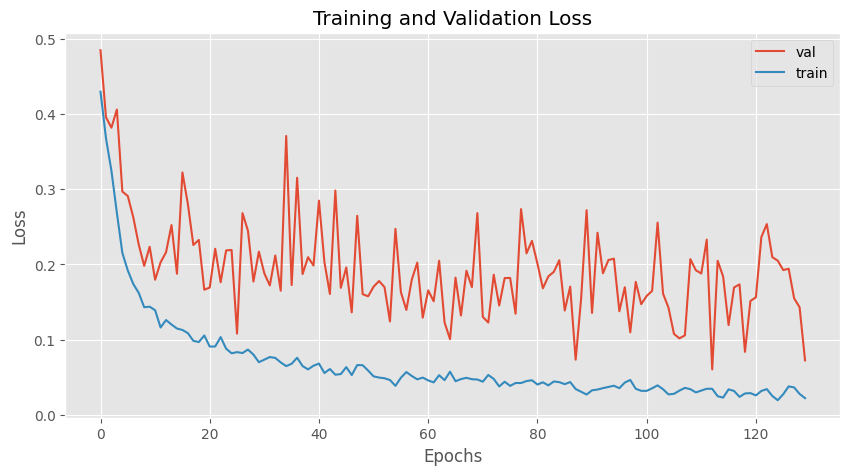

In [55]:
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

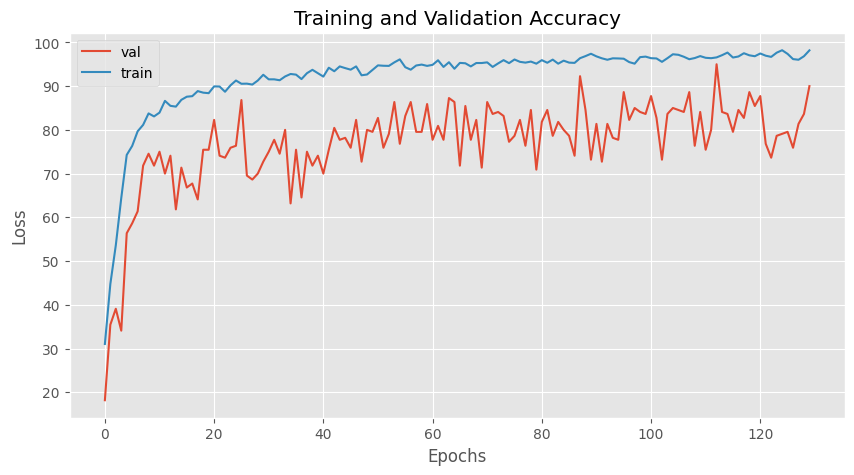

In [54]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_accs,label="val")
plt.plot(train_accs,label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [45]:
correct = 0
total = 0
net.to(device)
confusion_matrix = torch.zeros(6, 6, dtype=torch.int32)
with torch.no_grad():
    for i in tqdm(range(len(test_dataset))):
        real_class = torch.argmax(test_dataset[i][1].to('cuda'))
        x = test_dataset[i][0]
        x = x.unsqueeze(0)
        net_out = net(x.to('cuda'))[0] 
        predicted_class = torch.argmax(net_out)        
        #print (predicted_class.item(),real_class.item())        
        if predicted_class == real_class:
            correct += 1
        total += 1
        for t, p in zip(real_class.view(-1), predicted_class.view(-1)):
                confusion_matrix[t, p] += 1
print("Accuracy: ", round(correct/total, 10))

100%|███████████████████████████████████████████████████████████████████████████████| 882/882 [00:08<00:00, 100.54it/s]

Accuracy:  0.8378684807


In [ ]:
confusion_matrix

In [58]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


# iterate over test data
with torch.no_grad():
    y_pred = []
    y_true = []
    correct = 0
    net.eval()
    net.cpu()
    total = 0
    for inputs, labels in test_data_loader:
           
            
            output = net(inputs) # Feed Network
            
            pred = output.max(1).indices.to(device)
            
            true = labels.max(1).indices.to(device)
            
            output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) # Save Prediction
            
            labels = labels.max(1).indices.cpu().numpy()
            y_true.extend(labels) # Save Truth
            
            total += true.size(0)
            correct += torch.sum(pred == true)
# constant for classes
Classes = ('1', '3', '3', '4', '5','6')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

print("Accuracy: ", (correct/total).item())

Accuracy:  0.8163265585899353


Confusion matrix, without normalization
[[296  23   3   6   0  29]
 [  4 128   7   0   0   5]
 [  0   3  31   1   7   7]
 [  4   0   0  43   0   4]
 [  0   0   1   0  71   9]
 [  9   1   8   5  26 151]]


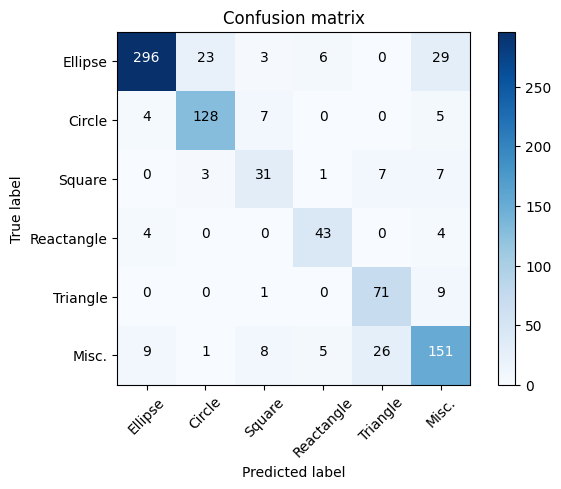

In [59]:
plt.style.use('default')
Classes = ('Ellipse', 'Circle', 'Square', 'Reactangle', 'Triangle','Misc.')
from plotcm import plot_confusion_matrix
plot_confusion_matrix(cf_matrix, Classes)

In [12]:
from torchsummary import summary
summary(net, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             216
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              ReLU-3         [-1, 24, 112, 112]               0
         MaxPool2d-4           [-1, 24, 56, 56]               0
            Conv2d-5           [-1, 24, 28, 28]             216
       BatchNorm2d-6           [-1, 24, 28, 28]              48
            Conv2d-7           [-1, 24, 28, 28]             576
       BatchNorm2d-8           [-1, 24, 28, 28]              48
              ReLU-9           [-1, 24, 28, 28]               0
           Conv2d-10           [-1, 24, 56, 56]             576
      BatchNorm2d-11           [-1, 24, 56, 56]              48
             ReLU-12           [-1, 24, 56, 56]               0
           Conv2d-13           [-1, 24, 28, 28]             216
      BatchNorm2d-14           [-1, 24,